## DOWNSTREAM SIGNALING DYNAMICS

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from msresist.pca import plotPCA
from scipy.stats import zscore

In [2]:
# Set plotting format
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

## Import and Preprocess Data

In [9]:
def preprocess(ts, utIDX, type="median"):
    ts.iloc[:, 3:] = np.log2(ts.iloc[:, 3:])
    for ii in utIDX:
        if type == "median":
            d = ts.iloc[ii:ii+13, 3:]
            ts.iloc[ii:ii+13, 3:] =  zscore(d)
        elif type == "UT":
            ts.iloc[ii:ii+13, 3:] /= ts.iloc[ii, 3:]
    return ts

In [34]:
# BR1
ts1 = pd.read_csv("msresist/data/Validations/Luminex/AXLm_TimeSeries_Signaling_BR1.csv")
utIDX = [i for i in range(0, 130, 13)]
ts1 = preprocess(ts1, utIDX, type="UT")
ts1["BR"] = 1

# Variables
cell_lines = list(ts1[(ts1["Treatment"] == "UT")]["Cell Line"])
tps = sorted(list(set(ts1["Time point"])))
prots = list(ts1.columns[3:])

In [35]:
# BR2
ts2 = pd.read_csv("msresist/data/Validations/Luminex/AXLm_TimeSeries_Signaling_BR2.csv")
ts2 = preprocess(ts2, utIDX, type="UT")
ts2["BR"] = 2

In [36]:
# # BR3
# ts3 = pd.read_csv("msresist/data/Validations/Luminex/AXLm_TimeSeries_Signaling_TR3.csv")
# ts3.insert(0, "Cell Line", [s.split(".")[0] for s in ts3["Sample"]])
# ts3.insert(1, "Treatment", [s.split(".")[-1] for s in ts3["Sample"]])
# ts3.insert(2, "Time point", [s.split(".")[1] for s in ts3["Sample"]])
# ts3 = ts3.drop("Sample", axis=1)
# ts3 = preprocess(ts3, utIDX)

In [37]:
# Merge
ts = pd.concat([ts1, ts2], axis=0)

<AxesSubplot:xlabel='Time point', ylabel='p-signal'>

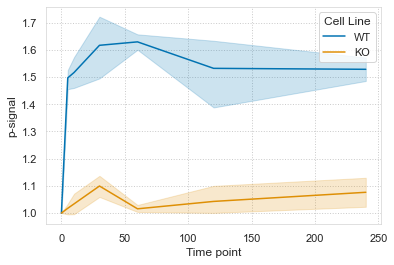

In [38]:
x2 = pd.melt(ts, id_vars=["Cell Line", "Treatment", "Time point"], value_vars=ts.columns[3:-1], value_name="p-signal", var_name="Proteins")
x2 = x2[(x2["Cell Line"] == "WT") | (x2["Cell Line"] == "KO")]
sns.lineplot(data=x2[x2["Proteins"] == "p-AXL"], x="Time point", y="p-signal", hue="Cell Line")

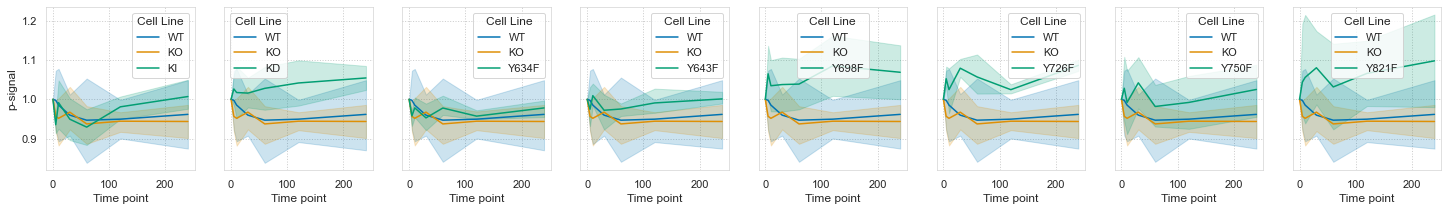

In [48]:
_, ax = plt.subplots(1, len(cell_lines) - 2, sharey=True, figsize=(25, 3))
x2 = pd.melt(ts, id_vars=["Cell Line", "Treatment", "Time point"], value_vars=ts.columns[3:-1], value_name="p-signal", var_name="Proteins")
for ii, cl in enumerate(cell_lines):
    if cl == "WT" or cl == "KO":
        continue
    x3 = x2[(x2["Cell Line"] == "WT") | (x2["Cell Line"] == cl) | (x2["Cell Line"] == "KO")]
    sns.lineplot(data=x3[x3["Proteins"] == "tAXL"], x="Time point", y="p-signal", hue="Cell Line", ax=ax[ii-2])

In [33]:
cell_lines

['WT', 'KO', 'KI', 'KD', 'Y634F', 'Y643F', 'Y698F', 'Y726F', 'Y750F', 'Y821F']

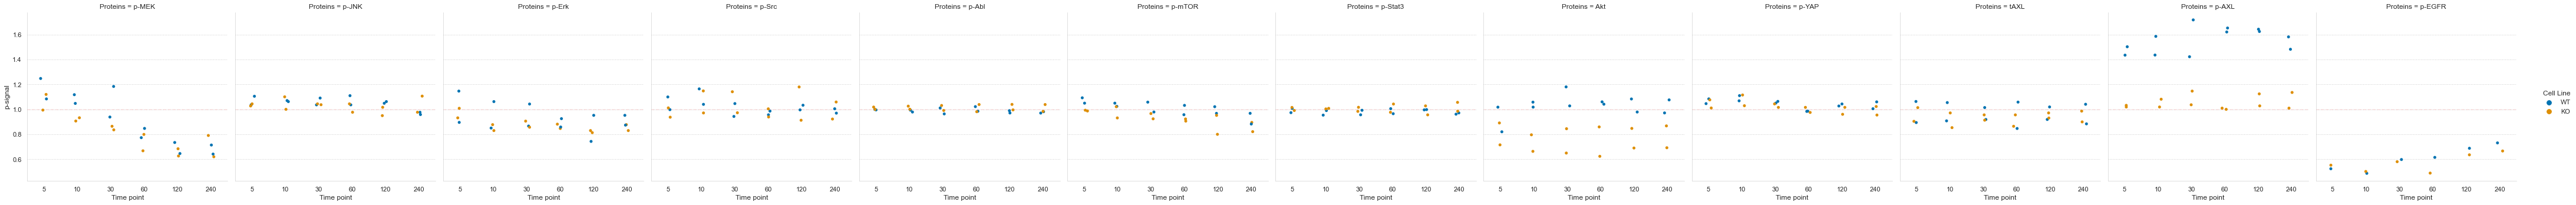

In [14]:
x = ts[(ts["Treatment"] == "AE") & (ts["Cell Line"] == "WT") | (ts["Cell Line"] == "KO") & (ts["Treatment"] == "AE")]
x = pd.melt(x, id_vars=["Cell Line", "Treatment", "Time point"], value_vars=x.columns[3:-1], value_name="p-signal", var_name="Proteins")
g = sns.catplot(data=x, x="Time point", y="p-signal", hue="Cell Line", col="Proteins")
axes = g.axes[0]
for ax in axes:
    ax.axhline(1, ls='--', color='red', **{"alpha":0.1})

plt.savefig("cat.svg")

In [40]:
ts1 = pd.read_csv("msresist/data/Validations/Luminex/AXLm_TimeSeries_Signaling_BR1.csv")
ts2 = pd.read_csv("msresist/data/Validations/Luminex/AXLm_TimeSeries_Signaling_BR2.csv")
ts = pd.concat([preprocess(ts1, utIDX), preprocess(ts2, utIDX)], axis=0)

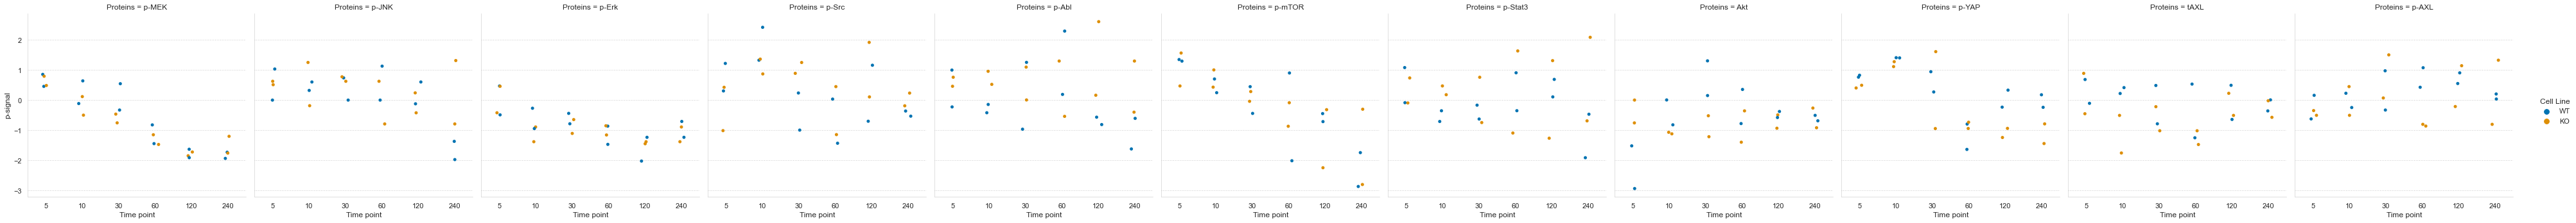

In [42]:
x = ts[(ts["Treatment"] == "AE") & (ts["Cell Line"] == "WT") | (ts["Cell Line"] == "KO") & (ts["Treatment"] == "AE")]
x = pd.melt(x, id_vars=["Cell Line", "Treatment", "Time point"], value_vars=x.columns[3:-1], value_name="p-signal", var_name="Proteins")
g = sns.catplot(data=x, x="Time point", y="p-signal", hue="Cell Line", col="Proteins")

## Overview of key data

In [121]:
def plot_all_analytes(cl, ts, prots):
    fig, ax = plt.subplots(3, 5, figsize=(20, 9), sharey=True)
    X = ts[ts["Cell Line"] == cl]
    X = pd.melt(frame=X, id_vars=["Time point", "Treatment", "Cell Line", "BR"], value_vars=X.columns[1:], value_name="p-signal", var_name="Protein").dropna()
    for ii, p in enumerate(prots[:-1]):
        d = X[X["Protein"] == p]
        if ii <= 4:
            xx = 0
        elif ii == 10:
            xx = 2
            ii = 0
        elif ii == 11:
            xx = 2
            ii = 1
        else:
            xx = 1
            ii -= 5

        sns.scatterplot(data=d, x="Time point", y="p-signal", hue="Treatment", style="BR", ax=ax[xx, ii])
        ax[xx, ii].legend().remove()
        if xx == 2 and ii == 0:
            ax[xx, ii].legend(loc="lower right")
        fig.tight_layout()
        ax[xx, ii].set_title(p)
    # plt.savefig("WT_luminexTS.png", dpi=300)


def plot_heatmap_TS(ts, psite, ax):
    prot = ts[["Cell Line", "Treatment", "Time point", psite]].set_index(["Cell Line", "Time point"])
    prot[psite] = prot[psite].replace(0, 0.0001)

    all_lines = ["WT", "KO", "KD", "KI", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F", "Y821F"]
    # prot = Linear(prot, "p-YAP")
    # protFC = pd.DataFrame(prot[prot["Treatment"] == "AE"].iloc[:, -1] - prot[prot["Treatment"] == "A"].iloc[:, -1])
    protFC = pd.DataFrame(prot[prot["Treatment"] == "A"].iloc[:, -1])
    protFC = protFC.pivot_table(index='Cell Line', columns='Time point')[psite].reset_index()
    protFC = protFC.set_index("Cell Line").reindex(all_lines)
    sns.heatmap(data=protFC.iloc[:, 1:], ax=ax, cbar_kws={'label': 'A'}, cmap="bwr")
    # sns.heatmap(data=protFC.iloc[:, 1:], ax=ax, cbar_kws={'label': 'FC(AE vs A)'}, cmap="bwr")
    ax.set_title(psite)

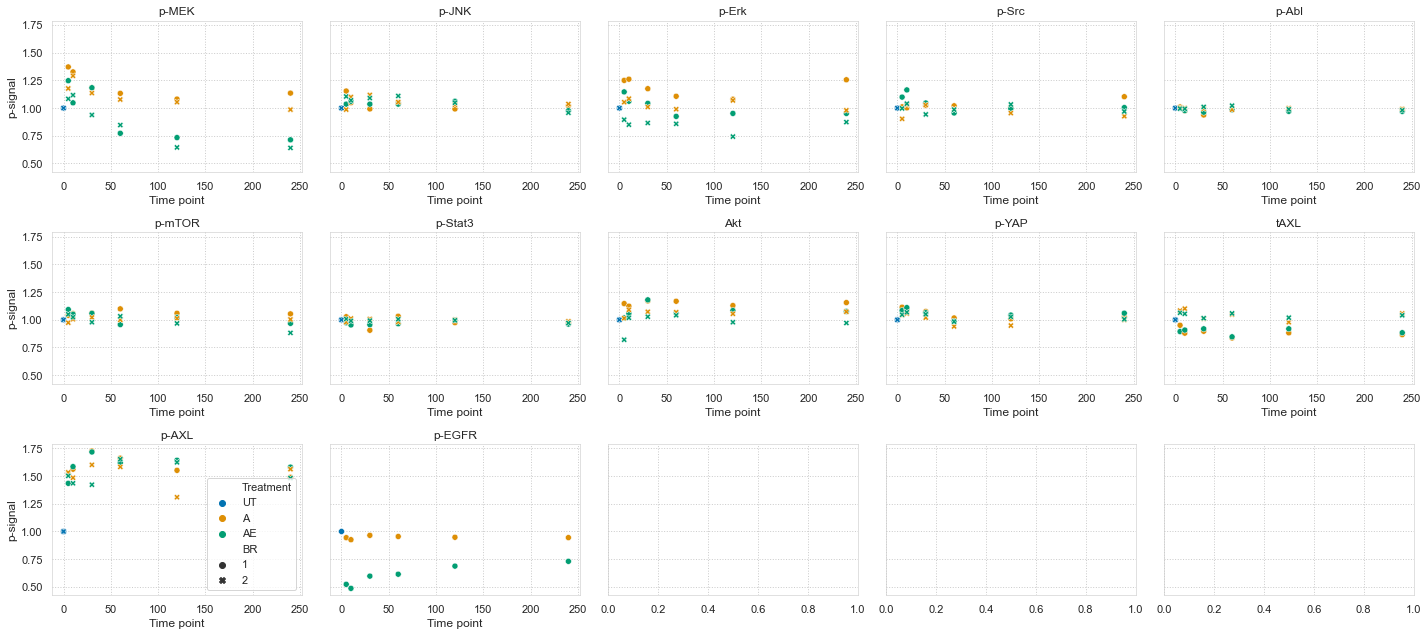

In [122]:
plot_all_analytes("WT", ts, prots)

In [70]:
from sklearn.decomposition import PCA
from msresist.pca import pca_dfs

n_components = 4
scores_ind = ["Cell Line", "Treatment"]

wt = ts[(ts["Cell Line"] == "WT") | (ts["Cell Line"] == "KO") | (ts["Cell Line"] == "UT")].drop("BR", axis=1)
wt.index = np.arange(wt.shape[0])
wt.iloc[:, 3:] = wt.iloc[:, 3:].astype(float)
wt.iloc[26:, -1] = wt.iloc[:26, -1]
loadings_ind = wt.columns[3:]

pp = PCA(n_components=n_components)
dScor_ = pp.fit_transform(wt.select_dtypes(include=["float64"]))
dLoad_ = pp.components_
dScor_, dLoad_ = pca_dfs(dScor_, dLoad_, wt, n_components, scores_ind, loadings_ind)
varExp = np.round(pp.explained_variance_ratio_, 2)

No handles with labels found to put in legend.


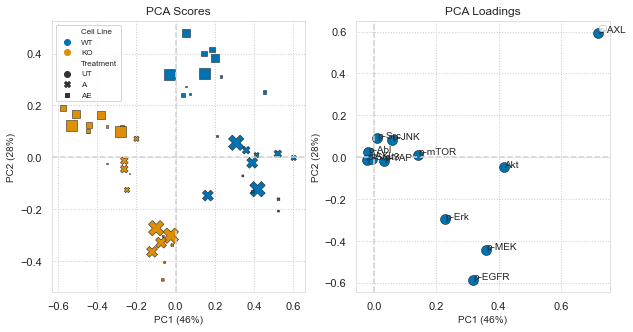

In [71]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
plotPCA(ax, wt, 2, ["Cell Line", "Treatment"], wt.columns[3:], hue_scores="Cell Line", style_scores="Treatment", size_dots=list(wt["Time point"]))

## PCA

In [10]:
from sklearn.decomposition import PCA
from msresist.pca import pca_dfs, plotPCA_scoresORloadings

In [11]:
n_components = 4
scores_ind = ["Cell Line", "Treatment", "Time point"]
loadings_ind = ts.columns[3:]

pp = PCA(n_components=n_components)
dScor_ = pp.fit_transform(ts.select_dtypes(include=["float64"]))
dLoad_ = pp.components_
dScor_, dLoad_ = pca_dfs(dScor_, dLoad_, ts, n_components, scores_ind, loadings_ind)
varExp = np.round(pp.explained_variance_ratio_, 2)

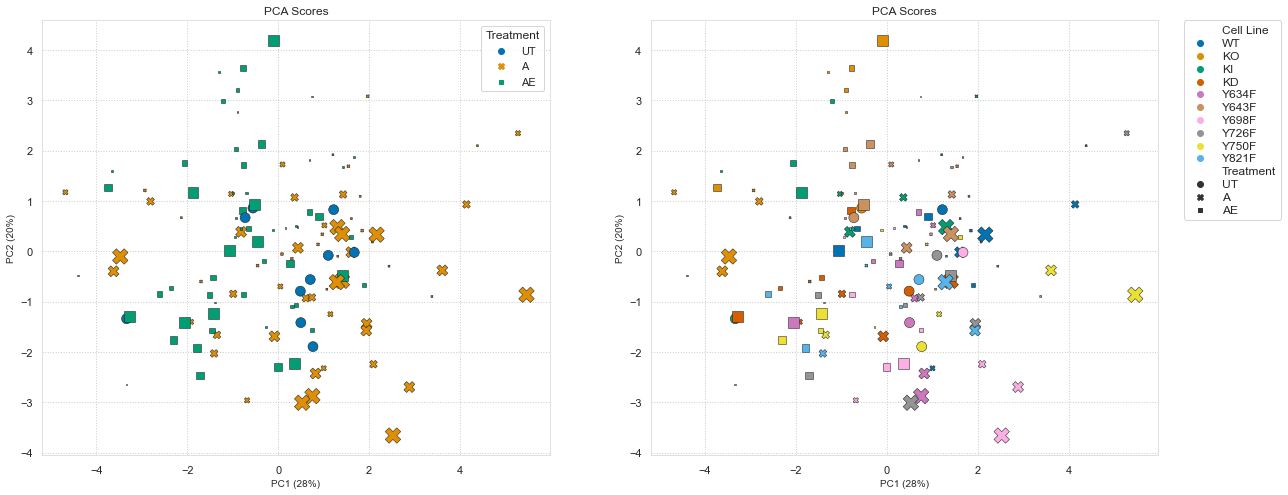

In [34]:
_, ax = plt.subplots(1, 2, figsize=(20, 8))
plotPCA_scoresORloadings(ax[0], ts, 4, scores_ind, loadings_ind, hue_scores="Treatment", style_scores="Treatment", size_dots=ts["Time point"].replace(0, 100), legendOut=False, plot="scores", annotateScores=False)
plotPCA_scoresORloadings(ax[1], ts, 4, scores_ind, loadings_ind, hue_scores="Cell Line", style_scores="Treatment", size_dots=ts["Time point"].replace(0, 100), legendOut=True)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labelspacing=0.2, prop={'size': 12})

## TENSOR DECOMPOSITION

In [10]:
from tensorly.decomposition import parafac
import tensorly as tl

### 1. Treatment (2) x Cell Line (10) x Time point (7) x Analyte (12) Tensor

### 1A) Full model

In [11]:
a = ts[(ts["Treatment"] == "UT") | (ts["Treatment"] == "A")].iloc[:, 3:].values.reshape((10, 7, 12))
ae = ts[(ts["Treatment"] == "UT") | (ts["Treatment"] == "AE")].iloc[:, 3:].values.reshape((10, 7, 12))
out_full = np.array([a, ae])
print(out_full.shape)

(2, 10, 7, 12)


0.38658104402491045


Text(0.5, 1.0, 'p-sites')

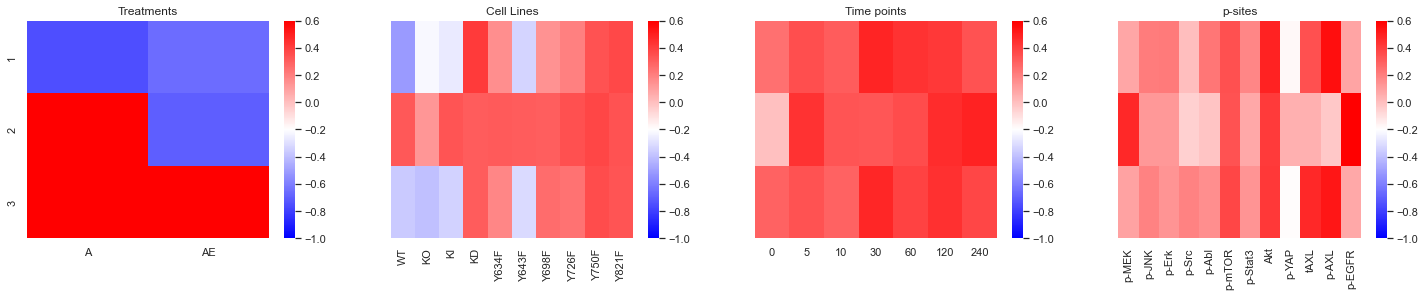

In [12]:
out = out_full

comp = 3
fac = parafac(out, comp, tol=1e-9, n_iter_max=5000, init="random", random_state=0)
fac = tl.cp_tensor.cp_flip_sign(fac)
fac.normalize()

# data variance
dvar = np.sum(np.square(out))
diffvar = np.sum(np.square(out - tl.cp_to_tensor(fac)))

# R2X
print(1.0 - diffvar / dvar)

comps = np.arange(comp) + 1 

# Plot
_, ax = plt.subplots(1, 4, figsize=(25, 4), sharey=True)

#Treatments
treatW = pd.DataFrame(fac.factors[0])
treatW.columns = comps
treatW.index = ["A", "AE"]
ax[0].set_title("Treatments")
ax[0].set_ylabel("Component")
sns.heatmap(treatW.T, ax=ax[0], vmin=-1, vmax=0.6, cmap="bwr")

# Cell Lines
mutsW = pd.DataFrame(fac.factors[1])
mutsW.columns = comps
mutsW.index = cell_lines
sns.heatmap(mutsW.T, ax=ax[1], vmin=-1, vmax=0.6, cmap="bwr")
ax[1].set_title("Cell Lines")

# Time points
tpW = pd.DataFrame(fac.factors[2])
tpW.columns = comps
tpW.index = tps
sns.heatmap(tpW.T, ax=ax[2], vmin=-1, vmax=0.6, cmap="bwr")
ax[2].set_title("Time points")

# Proteins
pW = pd.DataFrame(fac.factors[3])
pW.columns = comps
pW.index = prots
sns.heatmap(pW.T, ax=ax[3], vmin=-1, vmax=0.6, cmap="bwr")
ax[3].set_title("p-sites")

### 1A) AF154 only

0.46003800138086726


Text(0.5, 1.0, 'p-sites')

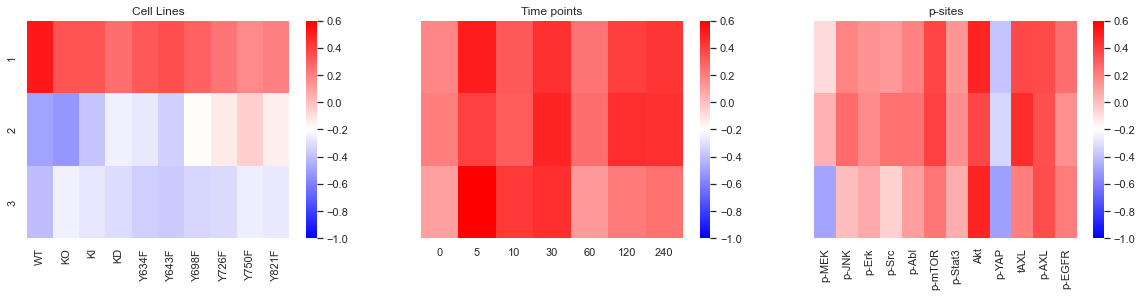

In [13]:
out = a

comp = 3
fac = parafac(out, comp, tol=1e-9, n_iter_max=5000, random_state=0)
fac = tl.cp_tensor.cp_flip_sign(fac)
fac.normalize()

# data variance
dvar = np.sum(np.square(out))
diffvar = np.sum(np.square(out - tl.cp_to_tensor(fac)))

# R2X
print(1.0 - diffvar / dvar)

comps = np.arange(comp) + 1 

# Plot
_, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)

# Cell Lines
mutsW = pd.DataFrame(fac.factors[0])
mutsW.columns = comps
mutsW.index = cell_lines
sns.heatmap(mutsW.T, ax=ax[0], vmin=-1, vmax=0.6, cmap="bwr")
ax[0].set_title("Cell Lines")

# Time points
tpW = pd.DataFrame(fac.factors[1])
tpW.columns = comps
tpW.index = tps
sns.heatmap(tpW.T, ax=ax[1], vmin=-1, vmax=0.6, cmap="bwr")
ax[1].set_title("Time points")

# Proteins
pW = pd.DataFrame(fac.factors[2])
pW.columns = comps
pW.index = prots
sns.heatmap(pW.T, ax=ax[2], vmin=-1, vmax=0.6, cmap="bwr")
ax[2].set_title("p-sites")

### 1B) EA

0.4615999430094707


Text(0.5, 1.0, 'p-sites')

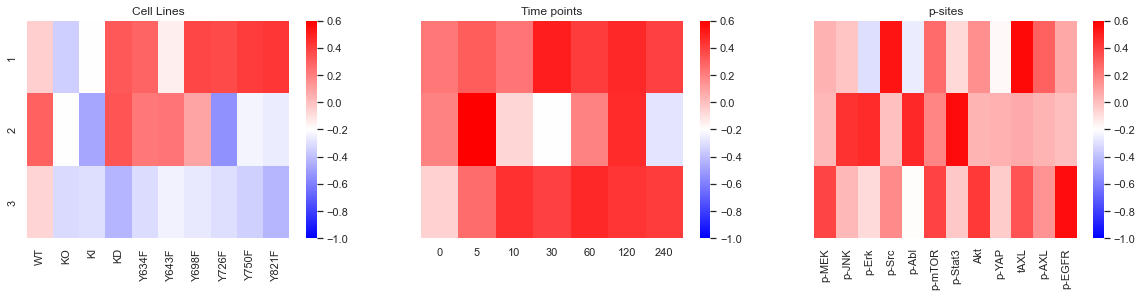

In [14]:
out = ae

comp = 3
fac = parafac(out, comp, tol=1e-9, n_iter_max=5000, random_state=0)
fac = tl.cp_tensor.cp_flip_sign(fac)
fac.normalize()

# data variance
dvar = np.sum(np.square(out))
diffvar = np.sum(np.square(out - tl.cp_to_tensor(fac)))

# R2X
print(1.0 - diffvar / dvar)

comps = np.arange(comp) + 1 

# Plot
_, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)

# Cell Lines
mutsW = pd.DataFrame(fac.factors[0])
mutsW.columns = comps
mutsW.index = cell_lines
sns.heatmap(mutsW.T, ax=ax[0], vmin=-1, vmax=0.6, cmap="bwr")
ax[0].set_title("Cell Lines")

# Time points
tpW = pd.DataFrame(fac.factors[1])
tpW.columns = comps
tpW.index = tps
sns.heatmap(tpW.T, ax=ax[1], vmin=-1, vmax=0.6, cmap="bwr")
ax[1].set_title("Time points")

# Proteins
pW = pd.DataFrame(fac.factors[2])
pW.columns = comps
pW.index = prots
sns.heatmap(pW.T, ax=ax[2], vmin=-1, vmax=0.6, cmap="bwr")
ax[2].set_title("p-sites")

### 2. Cell Line (10) x Time point & Treatment (14) x Analyte (12) Tensor

First need to duplicate rows when t=0h at the right location to be able to reshape. 

In [15]:
# Function to insert row in the dataframe
def insert_rows(row_number, df, row_value):
    # Slice the upper half of the dataframe
    df1 = df[0:row_number]
  
    # Store the result of lower half of the dataframe
    df2 = df[row_number:]
  
    # Insert the row in the upper half dataframe
    df1.loc[row_number]=row_value
  
    # Concat the two dataframes
    df_result = pd.concat([df1, df2])
  
    # Reassign the index labels
    df_result.index = [*range(df_result.shape[0])]
  
    # Return the updated dataframe
    return df_result
  
# Let's create a row which we want to insert
ut_df = ts[ts["Treatment"] == "UT"]
row_numbers = ut_df.index
row_value = ut_df

ts_ = ts.copy()
for ii, rN in enumerate(row_numbers):
    ts_ = insert_rows(rN + ii, ts_, row_value.iloc[ii, :])

out_flat = ts_.iloc[:, 3:].values.reshape((14, 10, 12))

/usr/local/lib/python3.9/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [16]:
out_flat = ts_.iloc[:, 3:].values.reshape((14, 10, 12))

In [17]:
out = out_flat
comp = 6
fac = parafac(out, comp, tol=1e-9, n_iter_max=5000, init="svd", random_state=1)
fac = tl.cp_tensor.cp_flip_sign(fac)
fac.normalize()

# data variance
dvar = np.sum(np.square(out))
diffvar = np.sum(np.square(out - tl.cp_to_tensor(fac)))

# R2X
print(1.0 - diffvar / dvar)

0.5174620680635451


Text(0.5, 1.0, 'p-sites')

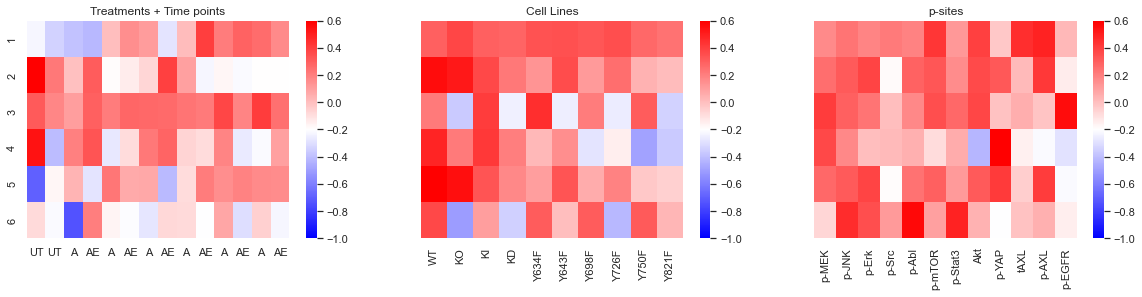

In [18]:
comps = np.arange(comp) + 1 

# Plot
_, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)

#Treatments
treatW = pd.DataFrame(fac.factors[0])
treatW.columns = comps
treatW.index = ["UT", "UT", "A", "AE", "A", "AE", "A", "AE", "A", "AE", "A", "AE" ,"A", "AE"]
sns.heatmap(treatW.T, ax=ax[0], vmin=-1, vmax=0.6, cmap="bwr")
ax[0].set_title("Treatments + Time points")

# Cell Lines
mutsW = pd.DataFrame(fac.factors[1])
mutsW.columns = comps
mutsW.index = cell_lines
sns.heatmap(mutsW.T, ax=ax[1], vmin=-1, vmax=0.6, cmap="bwr")
ax[1].set_title("Cell Lines")

# Proteins
pW = pd.DataFrame(fac.factors[2])
pW.columns = comps
pW.index = prots
sns.heatmap(pW.T, ax=ax[2], vmin=-1, vmax=0.6, cmap="bwr")
ax[2].set_title("p-sites")